# Querying SDO Data on NASA Pleiades

All code demonstrated here, including these notebooks, are available in a public repository: https://gitlab.com/wtbarnes/aia-on-pleiades

This notebook will demonstrate how to make queries against AIA and HMI data on the NASA Pleiades cluster.

In [22]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from sunpy.map import Map

sys.path.append('../../scripts/')
from drms_on_ames import Client

There is an instance of the netDRMS database running at Ames, meaning that the database can be queried in the same manner as the public netDRMS running at JSOC/Stanford. The data is available locally on a Lustre filesystem, allowing for fast I/O between the stored data and the computing resources.

The [`drms` package](https://github.com/sunpy/drms) provides a Python interface to the DRMS API such that queries can be made against the database in Python. 

We have subclassed `drms.Client` to provide a few minor changes needed to use the DRM running locally at Ames. Once the DRMS API is available as a local HTTP call, most of these changes will not be necessary. No changes were made to the underlying `drms` package.

To create a `drms` client,

In [2]:
c = Client(ssh=True)

(We set `ssh=True` when running on hosts other than `dfe1` as that is where the netDRMS instance is installed. When not on `dfe1`, commands are forwared through `ssh`. This will not be needed once netDRMS is reachable outside of `dfe1`.)

To list the available data series,

In [3]:
c.series()

['aia.lev1',
 'aia.lev1_euv_12s',
 'aia_test.lev1_12s4arc',
 'cgem.lorentz',
 'cgem.pdfi_input',
 'cgem.pdfi_output',
 'hmi.ic_720s',
 'hmi.m_45s',
 'hmi.m_720s',
 'hmi.v_45s',
 'hmi.v_720s',
 'hmi.v_avg120']

To get information about any of the data series,

In [4]:
aia_info = c.info('aia.lev1')

In [6]:
aia_info.segments

type     units protocol       dims                  note
name                                                                 
image_lev1  short        dn     fits  4096x4096  lev1 image fits file
bad_pixel     int  location     fits        VAR        bad pixel list
spikes        int  location     fits    VARxVAR     spiked pixel list

In [11]:
aia_info.primekeys

['T_REC', 'FSN']

In [25]:
aia_info.keywords[:10]  # List first 10 keywords

type  recscope         defval units  \
name                                                       
cparms_sg000       string  variable  compress Rice  none   
image_lev1_bzero   double  variable              0  none   
image_lev1_bscale  double  variable            0.5  none   
cparms_sg001       string  variable  compress Rice  none   
bad_pixel_bzero    double  variable              0  none   
bad_pixel_bscale   double  variable              1  none   
cparms_sg002       string  variable  compress Rice  none   
spikes_bzero       double  variable              0  none   
spikes_bscale      double  variable              1  none   
BLD_VERS           string  variable                 none   

                                                 note linkinfo  is_time  \
name                                                                      
cparms_sg000                                              None    False   
image_lev1_bzero                                          None    False   
image_lev1_bscale                                         None    False   
cparms_sg001                                              None    False   
bad_pixel_bzero                                           None    False   
bad_pixel_bscale                                          None    False   
cparms_sg002                                              None    False   
spikes_bzero                                              None    False   
spikes_bscale                                             None    False   
BLD_VERS           Build Version: from jsoc_version.h     None    False   

                   is_integer  is_real  is_numeric  
name                                                
cparms_sg000            False    False       False  
image_lev1_bzero        False     True        True  
image_lev1_bscale       False     True        True  
cparms_sg001            False    False       False  
bad_pixel_bzero         False     True        True  
bad_pixel_bscale        False     True        True  
cparms_sg002            False    False       False  
spikes_bzero            False     True        True  
spikes_bscale           False     True        True  
BLD_VERS                False    False       False

Most importantly, we can query data using several different criteria. For example, if we want 1 minute of AIA data around the well-studied 10 September 2017 flaring event,

In [19]:
q = c.query('aia_test.lev1_12s4arc[2017-09-10T15:30:00/1m]',
            seg=['image_lev1'])
# NOTE: change this to aia.lev1_euv_12s once shadow table is created

In [18]:
q[:5]

image_lev1
0  /nobackup/drms/SUM6/D1185288020/S00010/image_l...
1  /nobackup/drms/SUM6/D1185288020/S00014/image_l...
2  /nobackup/drms/SUM6/D1185288020/S00015/image_l...
3  /nobackup/drms/SUM6/D1185288020/S00012/image_l...
4  /nobackup/drms/SUM6/D1185288020/S00009/image_l...

Additionally, we can choose specific wavelengths to look at,

In [20]:
q = c.query('aia_test.lev1_12s4arc[2017-09-10T15:30:00/2m][131,171]',
            seg=['image_lev1'])

Note that these queries just return paths to files local to the cluster. We can use these directly to get the image data, for example, by constructing a `sunpy.map.Map` object.

In [26]:
m = Map(q['image_lev1'][0])

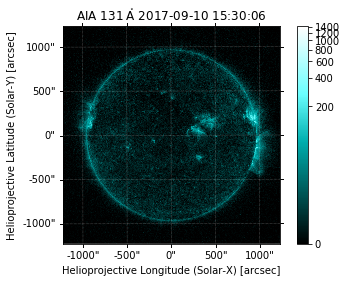

In [28]:
m.peek(vmin=0)

Note that because we are simply sublcassing the already developed `drms` package, the data are available through a familiar API such that users do not have to learn a new system for querying data.

Additionally, the `sunpy` package also provides a higher-level query interface called `Fido`. `Fido` relies on `drms` to perform queries against the JSOC database. Work is currently underway to provide an interface to the Ames `drms` via `Fido`.